In [1]:
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.loaders import StateInteractionsLoader
from drn_interactions.interactions.pairwise import PairwiseCorr
from drn_interactions.io import load_neurons, load_derived_generic
import seaborn as sns
import pandas as pd
import numpy as np
from drn_interactions.interactions.graph_clustering import SpectralCluster, ClusterRunner, ClusterEvaluation, ClusterResults
import warnings
from drn_interactions.config import Config, ExperimentInfo
from tqdm import tqdm

dd = Config.derived_data_dir / "ensembles"
dd.mkdir(exist_ok=True)
# sns.set_theme(style="ticks", context="paper")

c:\Users\roryl\.conda\envs\drn38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
def load_responders():
    bs_response = load_derived_generic("brain_states_spikerate_responders.csv")[
        ["neuron_id", "Diff", "sig"]
    ].assign(
        response_bs=lambda x: np.where(
            x["sig"] == False,
            "no_response",
            np.where(x["Diff"] < 0, "inhibited", "activated"),
        )
    )[["neuron_id", "response_bs"]]
    phase_lock_response  = (
        load_derived_generic("brain_states_phase_responders.csv")
        .pivot(index="neuron_id", columns="oscillation", values="p")
        [["delta", "theta"]]
        .transform(lambda x: x < 0.5)
        .rename(columns={"delta": "phase_lock_delta", "theta": "phase_lock_theta"})
        .reset_index()
        [["neuron_id", "phase_lock_delta", "phase_lock_theta"]]
    )
    df_responders = pd.merge(bs_response, phase_lock_response, on="neuron_id", how="outer")
    return df_responders


def reorder_df_affinity(df, ensemble_labels):
    idx = np.argsort(ensemble_labels)
    return df.iloc[idx, idx]

def get_true(
    df, 
    bin_width=1, 
    shuffle=False):
    return df.query("bin_width == @bin_width")

def get_labels_from_df_ensembles(df_ensembles, df_affinity, session, state):
    state_neurons = (
        df_ensembles
        .query("session_name == @session and state == @state")
    )
    if len(state_neurons) > 0:
        return (
            state_neurons
            .sort_values("neuron_id")
            ["ensemble_id"]
            .values
        )
    else:
        return [-1 for _ in df_affinity.columns]


def get_affinity(session, state):
    loader = StateInteractionsLoader(
        bin_width=1, 
        shuffle=False,
        session_name=session,
        state=state,
        )
    preprocessor = InteractionsPreprocessor()
    pairwise = PairwiseCorr(rectify=True)
    spikes = preprocessor(loader())
    return pairwise.fit(spikes).get_adjacency_df()


In [3]:
sessions = ExperimentInfo.eeg_sessions

preprocessor = InteractionsPreprocessor(z=True, minmax=False)
evaluator = ClusterEvaluation()

loader_fac = lambda session, state, bin_width: StateInteractionsLoader(
    session_name=session, state=state, bin_width=bin_width,
)
corr_fac = lambda: PairwiseCorr(
    remove_self_interactions=True,
    rectify=True,
    shuffle=False,
    remove_duplicate_combs=True,
    dropna=True,
)
cluster_fac = lambda: SpectralCluster(
    n_clusters=np.arange(2, 6), spectral_kws={"affinity": "precomputed"}, n_init=2
)

runner_fac = lambda session, state, bin_width: ClusterRunner(
    loader=loader_fac(session=session, state=state, bin_width=bin_width),
    preprocessor=preprocessor,
    affinity_calculator=corr_fac(),
    clusterer=cluster_fac(),
    evalulator=evaluator,
)

In [4]:
ensemble_frames = []
ensemble_stats_frames = []

for bin_width in (0.05, 0.1, 0.5, 1,):
    for state in ("sw", "act"):
        for session in tqdm(sessions):
            runner = runner_fac(session=session, state=state, bin_width=bin_width)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                try:
                    _, ensembles, _, ensemble_stats = runner.run(20)
                except ValueError as e:
                    print(e)
                    print(session)
                    continue

            # add metadata and append to list of results
            ensembles = ensembles.assign(session_name=session, state=state, bin_width=bin_width)
            ensemble_stats = ensemble_stats.assign(session_name=session, state=state, bin_width=bin_width)
            
            ensemble_stats_frames.append(ensemble_stats)
            ensemble_frames.append(ensembles)

df_ensembles = pd.concat(ensemble_frames).reset_index(drop=True)
df_ensembles_stats = pd.concat(ensemble_stats_frames).reset_index(drop=True)

df_ensembles_stats["ensemble_id"] = pd.factorize(
    df_ensembles_stats["ensemble"].astype(str)
    + df_ensembles_stats["session_name"]
    + df_ensembles_stats["state"]
    + df_ensembles_stats["bin_width"].astype(str)
)[0]
df_ensembles_stats["ensemble_id"] = np.where(
    df_ensembles_stats["ensemble"] == -1,
    -1,
    df_ensembles_stats["ensemble_id"],
)
df_ensembles = (
    df_ensembles.merge(
    df_ensembles_stats[["session_name", "ensemble", "ensemble_id", "state", "bin_width"]],
    on=["session_name", "ensemble", "state", "bin_width"]
    )
)

df_ensembles.to_csv(dd / "bs - ensembles.csv", index=False)
df_ensembles_stats.to_csv(dd / "bs - stats.csv", index=False)


### Ensemble Properties

Are the properties of ensembles different between the two states?

Properties:
- Size
- Average Weight
- Average Conductivity
- Edge Expantion


size
 n_sw         20.00
n_act        20.00
Mean_sw       9.90
Mean_act      9.20
Diff         -0.70
U           229.00
p             0.44
dtype: float64

average_weight
 n_sw         20.00
n_act        20.00
Mean_sw       0.37
Mean_act      0.33
Diff         -0.04
U           238.00
p             0.31
dtype: float64

average_weight_out
 n_sw         20.00
n_act        20.00
Mean_sw       0.11
Mean_act      0.12
Diff          0.00
U           203.00
p             0.95
dtype: float64

neuron_type_entropy
 n_sw         20.00
n_act        20.00
Mean_sw       1.20
Mean_act      0.94
Diff         -0.27
U           256.00
p             0.13
dtype: float64

response_bs_entropy
 n_sw         20.00
n_act        20.00
Mean_sw       0.92
Mean_act      0.94
Diff          0.02
U           199.50
p             1.00
dtype: float64


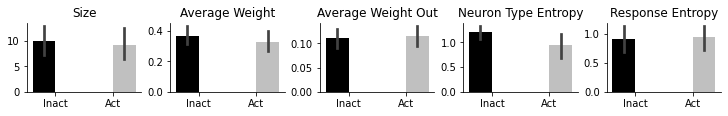

In [17]:
from drn_interactions.stats import mannwhitneyu_plusplus
import matplotlib.pyplot as plt
from drn_interactions.plots import PAL_GREY_BLACK

def compare_metric(df, metric):
    x = df.query("ensemble_id != -1 and state == 'sw'")[metric].values
    y = df.query("ensemble_id != -1 and state == 'act'")[metric].values
    return mannwhitneyu_plusplus(x, y, names=("sw", "act")).round(2)

def plot_metric(df, metric, ax, **kwargs):
    return (
        df
        .query("ensemble_id != -1")
        .pipe((sns.barplot, "data"), x="state", y=metric, hue="state", ax=ax, **kwargs)
    )


df_stats = pd.read_csv(dd / "bs - stats - true.csv")

f = plt.figure(figsize=(10, 1.5), constrained_layout=True)
axes = f.subplots(1, 5, sharex=True)

for i, (metric, lab) in enumerate(zip(
    ("size", "average_weight", "average_weight_out", "neuron_type_entropy", "response_bs_entropy"), 
    ("Size", "Average Weight", "Average Weight Out", "Neuron Type Entropy", "Response Entropy"),
    )):
    res = compare_metric(df_stats, metric)
    print(f"\n{metric}\n", res)
    ax = axes[i]
    plot_metric(df_stats, metric, ax, palette=PAL_GREY_BLACK)
    ax.legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel(ylab)
    ax.set_title(lab)
    ax.set_xticklabels(["Inact", "Act"])

sns.despine(fig=f)
    